### Янгаличин Олег 184-322

# Нейронная сеть и PyTorch

В предыдущем задании мы реализовали двухслойную нейронную сеть собственными силами, в этом задании необходимо реализовать ту же двухслойную нейронную сеть, но уже используя фреймворк PyTorch.

Порядок выполнения:
1. Используя фреймворк PyTorch создать нейронную сеть;
2. Загрузить базу данных CIFAR-10;
3. Разделить данные на выборки: обучающую, проверочную, тестовую;
4. Провести предварительную обработку данных;
5. Обучить нейронную сеть;
6. Подобрать гиперпараметры;
7. Оценить результаты на тестовой выборке.

Материалы на английском:
1. [PyTorch for Deep Learning: A Quick Guide for Starters](https://towardsdatascience.com/pytorch-for-deep-learning-a-quick-guide-for-starters-5b60d2dbb564)
2. [Building Neural Network Using PyTorch](https://towardsdatascience.com/building-neural-network-using-pytorch-84f6e75f9a)
3. [A Simple Neural Network from Scratch with PyTorch and Google Colab](https://medium.com/dair-ai/a-simple-neural-network-from-scratch-with-pytorch-and-google-colab-c7f3830618e0)
4. [Training Neural Network using PyTorch](https://towardsdatascience.com/training-a-neural-network-using-pytorch-72ab708da210)

Материал на русском:
1. [Туториал по PyTorch](https://neurohive.io/ru/tutorial/glubokoe-obuchenie-s-pytorch/)

In [2]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets
import torchvision.transforms as transforms
import time
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

In [25]:
#Уже посчитанные данные для Cifar-10
mean = {'cifar10': (0.4914, 0.4822, 0.4465)}
std = {'cifar10': (0.2023, 0.1994, 0.2010)}
##############################################
num_workers = 2
batch_size = 200

# Преобразуем данные для обучения
transform_train = transforms.Compose([
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean['cifar10'], std['cifar10']),
    ])
# Преоразуем данные для теста
transform_test = transforms.Compose([
        transforms.ToTensor()
    ])


# Загружаем данные Cifar-10
train_data = datasets.CIFAR10(root='data', train=True,
                                   download=True, transform=transform_train)
test_data = datasets.CIFAR10(root='data', train=False,
                                  download=True, transform=transform_test)

# инициализируем data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10000, 
    num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
#Делим выборки из train_loader на обучающую, валидационную и для разработки
train_data = torch.Tensor(train_loader.dataset.data[:45000, :, :])
val_data = torch.Tensor(train_loader.dataset.data[45000:, :, :])
dev_data = torch.Tensor(train_loader.dataset.data[:20000, :, :])

train_target = torch.Tensor(train_loader.dataset.targets[:45000])
val_target =  torch.Tensor(train_loader.dataset.targets[45000:])
dev_target =  torch.Tensor(train_loader.dataset.targets[:20000])

train_dl = torch.utils.data.DataLoader(TensorDataset(train_data, train_target), batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(TensorDataset(val_data, val_target), batch_size=batch_size, shuffle=True)
dev_dl = torch.utils.data.DataLoader(TensorDataset(dev_data, dev_target), batch_size=batch_size, shuffle=True)

print(f'Размер обучающей выборки = {len(train_dl.dataset)}')
print(f'Размер валидационной выборки = {len(val_dl.dataset)}')
print(f'Размер dev выборки = {len(dev_dl.dataset)}')

Размер обучающей выборки = 45000
Размер валидационной выборки = 5000
Размер dev выборки = 20000


In [38]:
#Инициализируем сеть
class Net(nn.Module):
    def __init__(self, hidden_nodes):
        
        super(Net, self).__init__()
        # Входной параметр - количетсва нейронов в скрытом слое
        self.hidden1 = hidden_nodes
        #Количество классов (нейронов на выходе)
        out_classes = 10
        # linear layer (3072 -> self.hidden1)
        self.l1 = nn.Linear(32 * 32 * 3, self.hidden1)
        # linear layer (self.hidden1 -> out_classes)
        self.l2 = nn.Linear(self.hidden1, out_classes)
        #self.dropout = nn.Dropout(0.2)

        
    def forward(self, x):
        #Feed Forward для сети
        # преобразуем данные в плоский вид
        x = x.view(-1, 32 * 32 * 3)
        # Первый слой с ReLU
        x = F.relu(self.l1(x))
        #x = self.dropout(x)
        #Второй слой с softmax 
        x = F.log_softmax(self.l2(x) , dim = 1)
        return x

# Смотрим модель
model = Net(10)
print(model)

Net(
  (l1): Linear(in_features=3072, out_features=10, bias=True)
  (l2): Linear(in_features=10, out_features=10, bias=True)
)


In [39]:
def train(epoch, model, train_loader, optimizer, log_interval=1, cuda=None):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
#         if cuda:
#             data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        target = target.long()
        optimizer.zero_grad()
        output = model.forward(data)

        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        accuracy = 100. * correct / len(train_loader.dataset)

        #loss_f = nn.CrossEntropyLoss()
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]  Loss: {:.6f} Accuracy: {}'.format(
                epoch, (batch_idx+1) * len(data) , len(train_loader.dataset),
                100. * (batch_idx+1) / len(train_loader), loss.data.item(), accuracy) , end='\r')
    print()
    return loss.data.item(), accuracy

In [40]:
def validate(model, validation_loader, cuda=None):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
#         if cuda:
#             data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        target = target.long()
        output = model.forward(data)
        val_loss += F.nll_loss(output, target)#.data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)

    accuracy = 100. * correct / len(validation_loader.dataset)

    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy), end = '\r')
    return val_loss , accuracy

In [41]:
def test(model, test_loader, cuda=None):
    model.eval()
    torch.no_grad()
    correct = 0
    for data, target in test_loader:
#         if cuda:
#             data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        target = target.long()
        output = model.forward(data)
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset), accuracy), end = '\r')

 ITERATION 1, lr = 1e-05 , hidden nodes = 3072
-----------------------------------------------------------------------------------
Train Epoch: 1 [45000/45000 (100%)]  Loss: 8.573359 Accuracy: 19.053333282470703
Validation set: Average loss: 8.4305, Accuracy: 1228/5000 (25%)
Best accuracy = 24.559999465942383, checkpoint saved!
###################################################################################
Train Epoch: 2 [45000/45000 (100%)]  Loss: 10.882666 Accuracy: 23.920000076293945
Validation set: Average loss: 11.2028, Accuracy: 1225/5000 (24%)
###################################################################################
Train Epoch: 3 [45000/45000 (100%)]  Loss: 7.843499 Accuracy: 26.382223129272464
Validation set: Average loss: 7.4731, Accuracy: 1267/5000 (25%)
Best accuracy = 25.34000015258789, checkpoint saved!
###################################################################################
Train Epoch: 4 [45000/45000 (100%)]  Loss: 7.023156 Accuracy: 28.21555519

Train Epoch: 33 [45000/45000 (100%)]  Loss: 2.610291 Accuracy: 42.331111907958984
Validation set: Average loss: 2.9536, Accuracy: 1911/5000 (38%)
Best accuracy = 38.220001220703125, checkpoint saved!
###################################################################################
Train Epoch: 34 [45000/45000 (100%)]  Loss: 2.424204 Accuracy: 42.697776794433594
Validation set: Average loss: 3.1228, Accuracy: 1867/5000 (37%)
###################################################################################
Train Epoch: 35 [45000/45000 (100%)]  Loss: 2.258419 Accuracy: 42.51555633544922
Validation set: Average loss: 2.9261, Accuracy: 1894/5000 (38%)
###################################################################################
Train Epoch: 36 [45000/45000 (100%)]  Loss: 2.444757 Accuracy: 43.537776947021484
Validation set: Average loss: 3.0698, Accuracy: 1853/5000 (37%)
###################################################################################
Train Epoch: 37 [45000/4500

Train Epoch: 67 [45000/45000 (100%)]  Loss: 1.872870 Accuracy: 49.702220916748055
Validation set: Average loss: 2.6192, Accuracy: 1921/5000 (38%)
###################################################################################
Train Epoch: 68 [45000/45000 (100%)]  Loss: 1.754014 Accuracy: 49.831111907958984
Validation set: Average loss: 2.4894, Accuracy: 1999/5000 (40%)
###################################################################################
Train Epoch: 69 [45000/45000 (100%)]  Loss: 1.662218 Accuracy: 50.27333450317383
Validation set: Average loss: 2.8660, Accuracy: 1856/5000 (37%)
###################################################################################
Train Epoch: 70 [45000/45000 (100%)]  Loss: 1.653847 Accuracy: 50.32222366333008
Validation set: Average loss: 2.5536, Accuracy: 1931/5000 (39%)
###################################################################################
Train Epoch: 71 [45000/45000 (100%)]  Loss: 1.715719 Accuracy: 50.431110382080084


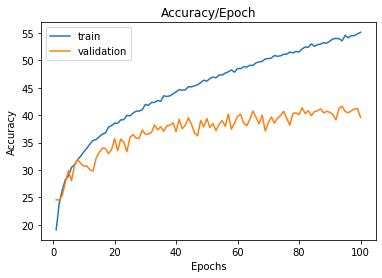

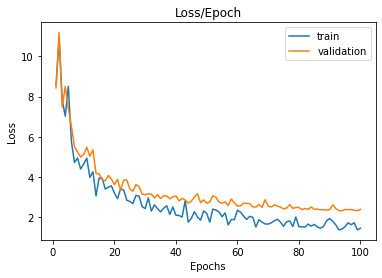

Total time 2525.451221704483


In [42]:
PLOT = True
EPOCHS = 100 #25
start_time = time.time()
# Тут подбирал гиперпараметры на 25 итерациях, потом провел 100 итераций на лучшем наборе гиперпараметров
LEARNING_RATES = [1e-5]#, 1e-6, 1e-7]
hidden_nodes = [32*32*3]#, 1000, 100]
best_tr_acc = -1.
best_val_acc = -1.
best_tr_loss = -1.
best_val_loss = -1.
acc_min = -1
k = 0

for lr in LEARNING_RATES:
    for hn in hidden_nodes:
        k+=1
        print(f' ITERATION {k}, lr = {lr} , hidden nodes = {hn}')
        print('-----------------------------------------------------------------------------------')
        model = Net(hn)
        # if cuda:
        #     model.cuda()
        optimizer = torch.optim.SGD(model.parameters(), lr = lr) #lr=LEARNING_RATES[i])

        loss_vector = {'train_loss':[],'val_loss':[]}
        acc_vector = {'train_acc':[],'val_acc':[]}
        for epoch in range(1, EPOCHS+1):
            loss_tr, acc_tr = train(epoch, model, train_dl, optimizer, cuda=None)
            acc_vector['train_acc'].append(acc_tr)
            loss_vector['train_loss'].append(loss_tr)
            loss_val, acc_val = validate(model, val_dl, cuda=None)
            acc_vector['val_acc'].append(acc_val)
            loss_vector['val_loss'].append(loss_val)
            if  acc_val >= acc_min:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss_val,
                    'acc' : acc_val,
                    'lr': lr,
                    'hidden nodes': hn
                    }, './checkpoint.pth')
                best_tr_acc = acc_tr
                best_val_acc = acc_val
                best_tr_loss = loss_tr
                best_val_loss = loss_val
                acc_min = acc_val
                print(f'Best accuracy = {acc_val}, checkpoint saved!')
            print('###################################################################################')
#             if epoch == 25:
#                 break

        if PLOT:
            epochs = [i for i in range(1, EPOCHS+1)]
            plt.plot(epochs, acc_vector['train_acc'], label='train')
            plt.plot(epochs, acc_vector['val_acc'], label='validation')
            plt.title('Accuracy/Epoch')
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.show()

            plt.plot(epochs, loss_vector['train_loss'], label='train')
            plt.plot(epochs, loss_vector['val_loss'], label='validation')
            plt.title('Loss/Epoch')
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()
end_time = time.time() - start_time   
print("Total time", end_time)

In [43]:


checkpoint = torch.load('./checkpoint.pth')
best_model = Net(checkpoint['hidden nodes'])
model.eval()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-5)
best_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
acc = checkpoint['acc']
hn = checkpoint['hidden nodes']
lr = checkpoint['lr']



print(f'Best validation accuracy {acc} , loss {loss} , in epoch {epoch} , lr = {lr} , hidden nodes = {hn}')

Best validation accuracy 41.619998931884766 , loss 2.316906690597534 , in epoch 94 , lr = 1e-05 , hidden nodes = 3072


In [45]:
test(best_model, val_dl, None)

Test set: Accuracy: 2081/5000 (42%)
